## Discretization

- The process of transfoming continuous variables into descrete variables. This is also called **binning*.

#### Discretization helps handle outliers and may improve the value spread in skewed variables

#### Approaches

##### Unsupervised discretization methods

- Equal width discretization
- Equal frequency discretization
- K-means discretization

##### Supervised discretization methods
- Discretization using decision trees

### Equal width discretization
- Divives the scope of possible values into N bins of the same width:
width = (max value - min value) / N


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

TEST_SIZE = 0.3
RANDOM_STATE = 42

In [3]:
data = pd.read_csv(
    "../data/titanic.csv",
    usecols = ['age', 'fare', 'survived']
)
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("survived", axis=1),
    data["survived"],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [5]:
X_train.isna().sum()

age     187
fare      1
dtype: int64

In [6]:
X_test.isna().sum()

age     76
fare     0
dtype: int64

In [7]:
def impute_na(data, variable):
    df = data.copy()
    imputing_column = variable + '_random'
    df[imputing_column] = df[variable]
    random_sample = X_train[variable].dropna().sample(
        df[variable].isna().sum(), random_state=RANDOM_STATE
    )
    random_sample.index = df[df[variable].isna()].index
    df.loc[df[variable].isna(), imputing_column] = random_sample

    return df[imputing_column]


In [13]:
X_train["age"] = impute_na(X_train, "age")
X_test["age"] = impute_na(X_test, "age")

X_train["fare"] = impute_na(X_train, "fare")
X_test["fare"] = impute_na(X_test, "fare")

In [14]:
X_train.isna().sum()

age     0
fare    0
dtype: int64

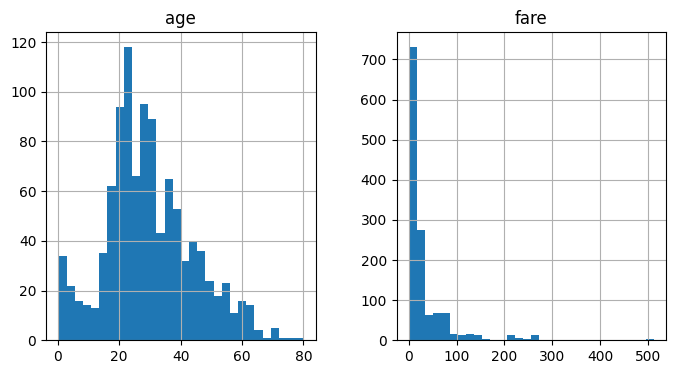

In [15]:
# distrivution of age
data[["age", "fare"]].hist(bins=30, figsize=(8,4))
plt.show()

In [16]:
# discretization
disc = KBinsDiscretizer(
    n_bins=8,
    encode="ordinal",
    strategy="uniform",
    subsample=None
)

disc.set_output(transform="pandas")
disc.fit(X_train[["age", "fare"]])

,n_bins,8
,encode,'ordinal'
,strategy,'uniform'
,quantile_method,'warn'
,dtype,None
,subsample,None
,random_state,None


In [17]:
disc.bin_edges_

array([array([ 0.1667   , 10.1458625, 20.125025 , 30.1041875, 40.08335  ,
              50.0625125, 60.041675 , 70.0208375, 80.       ])           ,
       array([  0.     ,  64.04115, 128.0823 , 192.12345, 256.1646 , 320.20575,
              384.2469 , 448.28805, 512.3292 ])                                ],
      dtype=object)

In [18]:
train_t = disc.transform(X_train[["age", "fare"]])
test_t = disc.transform(X_test[["age", "fare"]])

train_t.head()

,age,fare
1214,2.0,0.0
677,2.0,0.0
534,1.0,0.0
1174,3.0,1.0
864,2.0,0.0


In [21]:
train_t["age"].value_counts()

age
2.0    328
3.0    182
1.0    148
4.0    117
0.0     73
5.0     48
6.0     17
7.0      3
Name: count, dtype: int64

In [22]:
train_t["fare"].value_counts()

fare
0.0    791
1.0     80
2.0     16
3.0     15
4.0     11
7.0      3
Name: count, dtype: int64

Text(0, 0.5, 'Number of observations per bin')

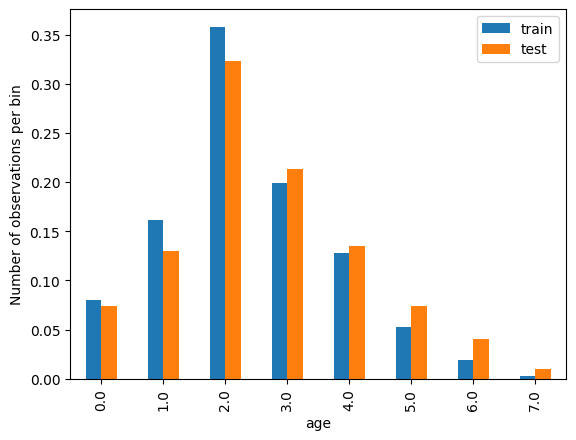

In [19]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = train_t["age"].value_counts(normalize=True).sort_index()
t2 = test_t["age"].value_counts(normalize=True).sort_index()

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ["train", "test"]
tmp.plot.bar()
plt.ylabel("Number of observations per bin")